# **Data Defination and Wrangling**

> # **Data Wrangling Using HiveQL**

In [3]:
# Instantiate PySpark Liberaries
from pyspark.sql import SparkSession

# Create Spark session with Hive support
spark = SparkSession.builder \
    .appName("HiveIntegrationExample") \
    .enableHiveSupport() \
    .getOrCreate()

In [5]:
import os
os.getcwd()

'/home/jovyan/work'

In [ ]:
# Showing Hive SQL databases
df = spark.sql("CREATE DATABASE assessment_boneAge_analysis")

In [4]:
df = spark.sql("SHOW DATABASES")
df.show()

+--------------------+
|           namespace|
+--------------------+
|assessment_boneag...|
|             default|
+--------------------+



In [ ]:
df = spark.sql("USE assessment_boneAge_analysis")
df = spark.sql("CREATE TABLE boneage_anal_data (idx INT, id INT, boneage INT, male BOOLEAN) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' STORED AS TEXTFILE")

In [6]:
df = spark.sql("USE assessment_boneAge_analysis")
df = spark.sql("SHOW TABLES")
df.show()

+--------------------+-------------------+-----------+
|           namespace|          tableName|isTemporary|
+--------------------+-------------------+-----------+
|assessment_boneag...|  boneage_anal_data|      false|
|assessment_boneag...|boneage_anal_images|      false|
+--------------------+-------------------+-----------+



In [38]:
df = spark.sql("LOAD DATA INPATH '/home/jovyan/work/data/boneage_dataset.csv' INTO TABLE boneage_anal_data")

In [9]:
df = spark.sql("SELECT * FROM boneage_anal_data LIMIT 10")
df.show()

+----+----+-------+-----+
| idx|  id|boneage| male|
+----+----+-------+-----+
|null|null|   null| null|
|   0|1377|    180|false|
|   1|1378|     12|false|
|   2|1379|     94|false|
|   3|1380|    120| true|
|   4|1381|     82|false|
|   5|1382|    138| true|
|   6|1383|    150| true|
|   7|1384|    156| true|
|   8|1385|     36| true|
+----+----+-------+-----+



In [71]:
# Pupulate / generate image metadata from data file to populated metadata table Hive;
# Instantiating Library
import pandas as pd

# Loading CSV file
df = pd.read_csv("data/boneage_dataset.csv")

# Create a new DataFrame with the required schema, since the 'id' column exists in the original dataset
image_metadata = pd.DataFrame()
image_metadata['id'] = df['id']
image_metadata['image_path'] = image_metadata['id'].apply(lambda x: f'data/boneage-images/{x}.png')

# Save the new DataFrame to a CSV file
image_metadata.to_csv("data/boneage_images.csv", index=False)

print("Image metadata table CSV is generated... .")

Image metadata table CSV is generated... .


In [73]:
df = spark.sql("CREATE TABLE boneage_anal_images (id INT, image_path STRING) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' STORED AS TEXTFILE")

In [74]:
# Loading data from file generated 
df = spark.sql("LOAD DATA LOCAL INPATH '/home/jovyan/work/data/boneage_images.csv'INTO TABLE boneage_anal_images")

In [10]:
# However, table only show null
df = spark.sql("SELECT * FROM boneage_anal_images LIMIT 10")
df.show()

+----+--------------------+
|  id|          image_path|
+----+--------------------+
|null|          image_path|
|1377|data/boneage-imag...|
|1378|data/boneage-imag...|
|1379|data/boneage-imag...|
|1380|data/boneage-imag...|
|1381|data/boneage-imag...|
|1382|data/boneage-imag...|
|1383|data/boneage-imag...|
|1384|data/boneage-imag...|
|1385|data/boneage-imag...|
+----+--------------------+



In [19]:
# Join Image Metadata with Bone Age Data
df = spark.sql("SELECT d.id, d.boneage, d.male, i.image_path FROM boneage_anal_data d JOIN boneage_anal_images i ON d.id = i.id")
df.show(5)

+----+-------+-----+--------------------+
|  id|boneage| male|          image_path|
+----+-------+-----+--------------------+
|1377|    180|false|data/boneage-imag...|
|1378|     12|false|data/boneage-imag...|
|1379|     94|false|data/boneage-imag...|
|1380|    120| true|data/boneage-imag...|
|1381|     82|false|data/boneage-imag...|
+----+-------+-----+--------------------+
only showing top 5 rows



In [41]:
# Describe prompt only return columns and datatypes
spark.sql("DESCRIBE boneage_anal_data")

DataFrame[col_name: string, data_type: string, comment: string]

In [16]:
# Count Records
spark.sql("SELECT COUNT(*) AS total_records FROM boneage_anal_data").show()

+-------------+
|total_records|
+-------------+
|        12612|
+-------------+



In [17]:
# Count by genda
spark.sql("SELECT male, COUNT(*) AS count FROM boneage_anal_data GROUP BY male").show()

+-----+-----+
| male|count|
+-----+-----+
| null|    1|
| true| 6833|
|false| 5778|
+-----+-----+



In [18]:
# Average BoneAge by Groups
spark.sql("SELECT male, AVG(boneage) AS avg_boneage FROM boneage_anal_data GROUP BY male").show()

+-----+------------------+
| male|       avg_boneage|
+-----+------------------+
| null|              null|
| true| 135.3036733499195|
|false|117.88023537556248|
+-----+------------------+



In [22]:
# Bone Ages Below 1st Percentile or Above 99th Percentile (approximation)
spark.sql("SELECT * FROM boneage_anal_data WHERE boneage < 18 OR boneage > 216").show(5)

+---+----+-------+-----+
|idx|  id|boneage| male|
+---+----+-------+-----+
|  1|1378|     12|false|
| 18|1398|      4|false|
| 85|1473|     12|false|
|127|1518|     13| true|
|150|1545|     12| true|
+---+----+-------+-----+
only showing top 5 rows



In [24]:
# Count of rows with missing values
spark.sql("SELECT COUNT(*) FROM boneage_anal_data WHERE id IS NULL OR male IS NULL OR boneage IS NULL").show()

+--------+
|count(1)|
+--------+
|       1|
+--------+



In [38]:
# Finding rows with missing values in a specific column
spark.sql("SELECT * FROM boneage_anal_data WHERE id IS NULL AND boneage IS NULL AND male IS NULL").show()

+----+----+-------+----+
| idx|  id|boneage|male|
+----+----+-------+----+
|null|null|   null|null|
+----+----+-------+----+



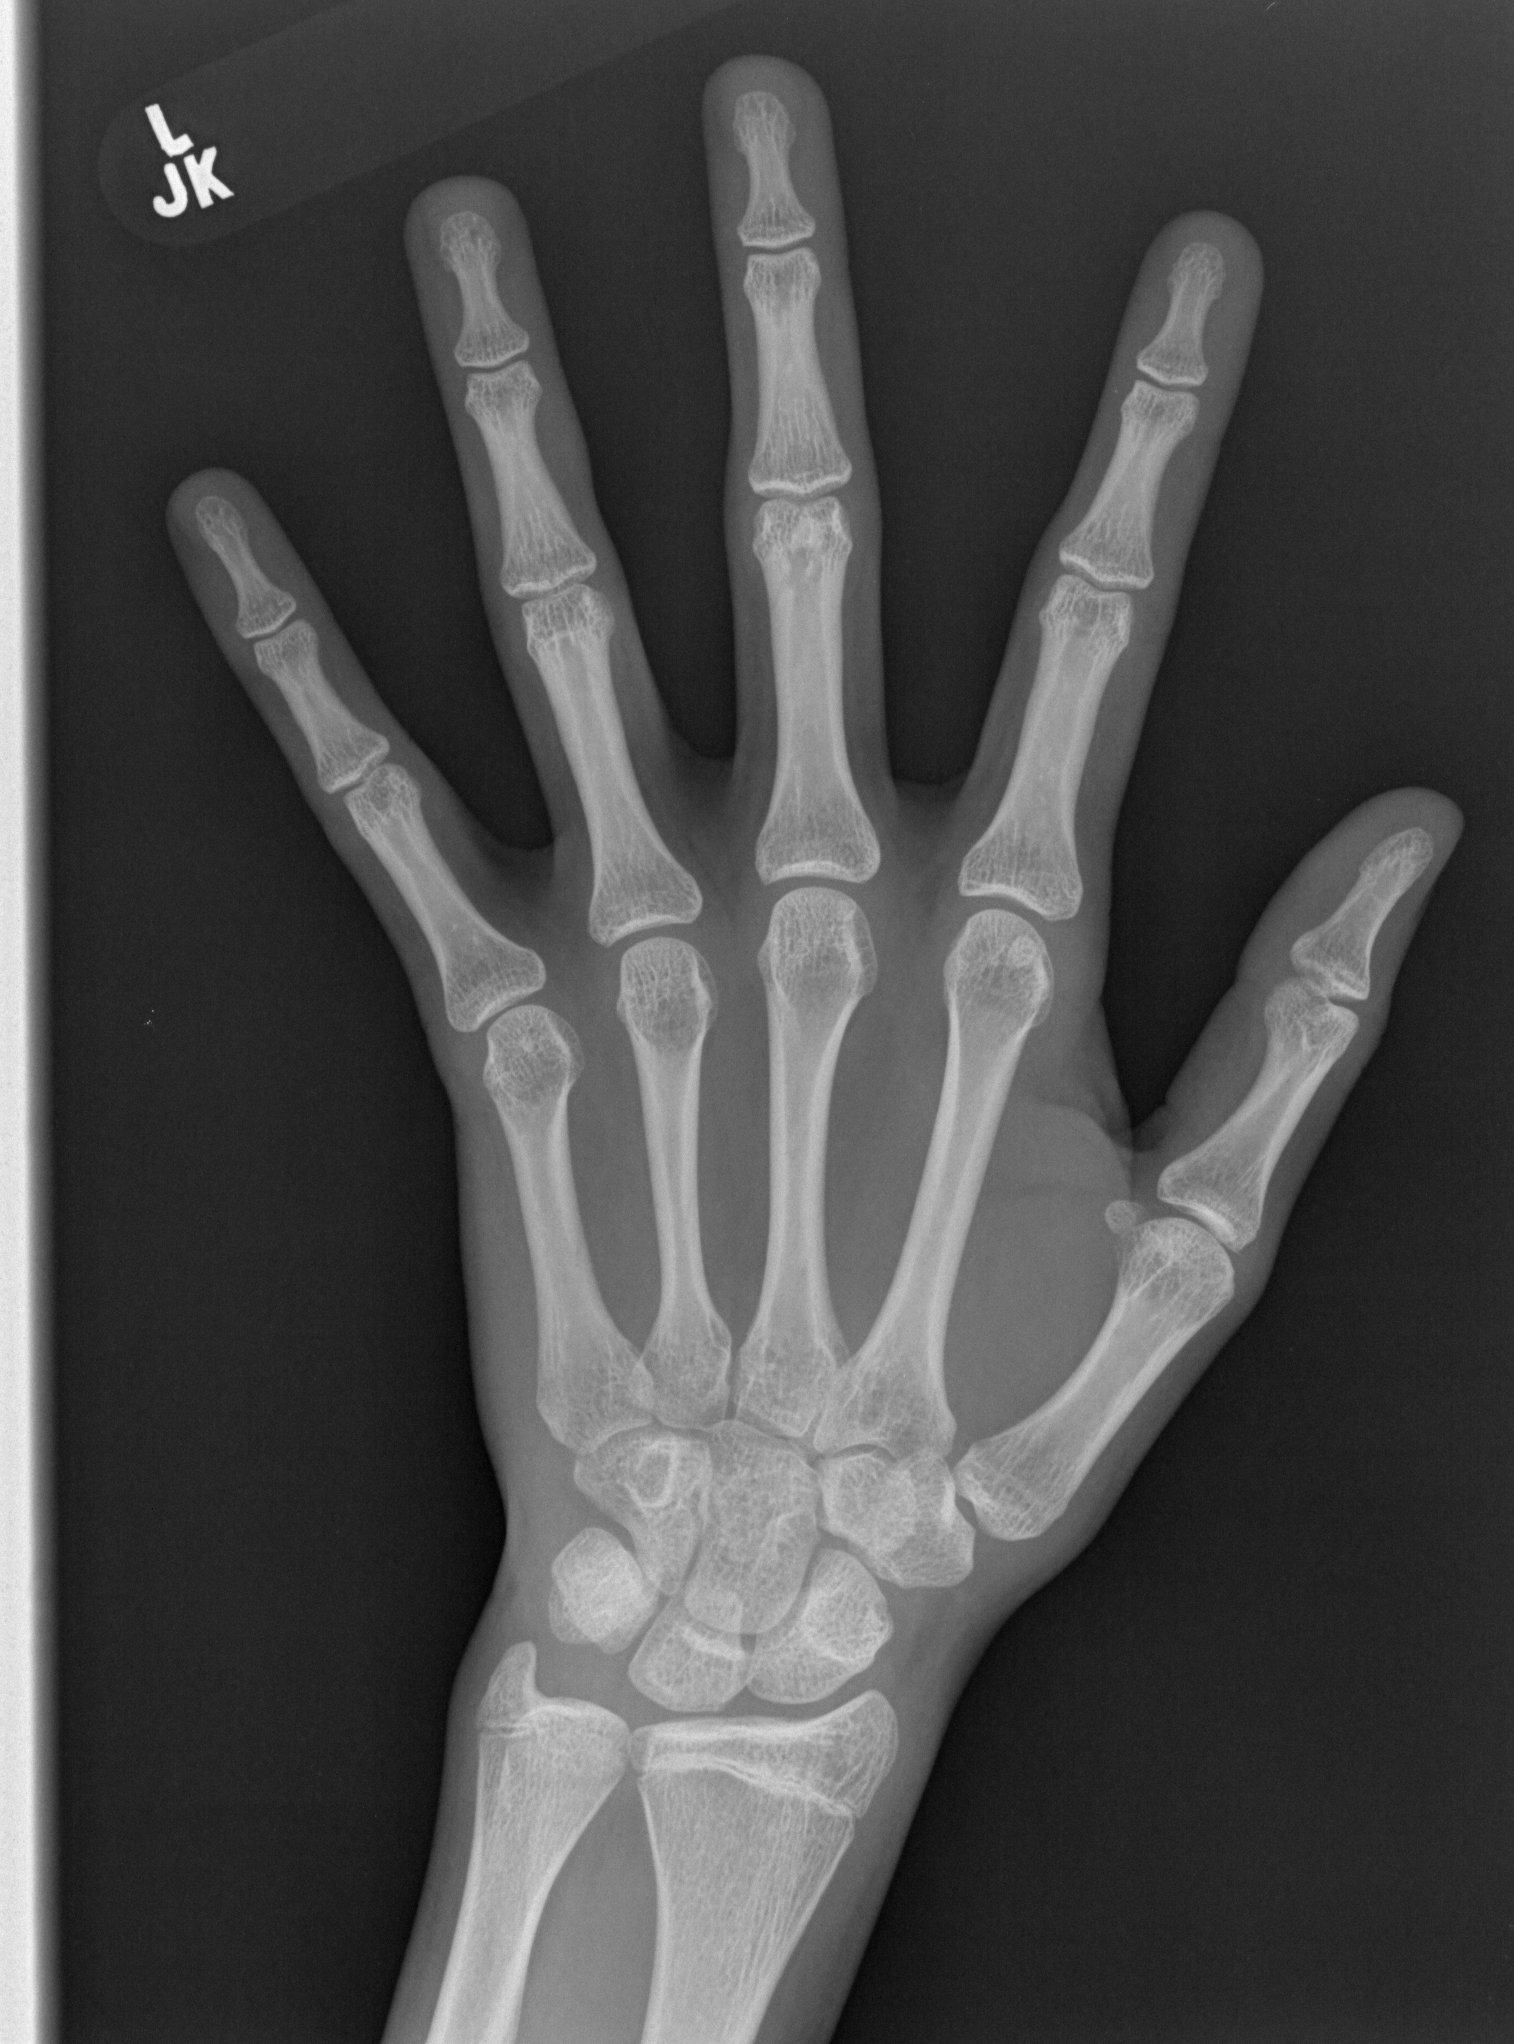

In [11]:
# Instantiating image library to Stes Image link
from IPython.display import Image, display

# Displaying image link
image_path = "data/boneage-images/1377.png"
display(Image(filename=image_path))

> # **Data Wrangling Using PySpark**

In [29]:
# Load both tables
data_df = spark.table("boneage_anal_data")
meta_df = spark.table("boneage_anal_images")

In [30]:
data_df.show(5)                  # Show first 5 rows
data_df.printSchema()            # Print schema (data types)
# data_df.columns().show()                  # List of column names
data_df.describe().show()        # Summary statistics

+----+----+-------+-----+
| idx|  id|boneage| male|
+----+----+-------+-----+
|null|null|   null| null|
|   0|1377|    180|false|
|   1|1378|     12|false|
|   2|1379|     94|false|
|   3|1380|    120| true|
+----+----+-------+-----+
only showing top 5 rows

root
 |-- idx: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- boneage: integer (nullable = true)
 |-- male: boolean (nullable = true)

+-------+------------------+-----------------+-----------------+
|summary|               idx|               id|          boneage|
+-------+------------------+-----------------+-----------------+
|  count|             12611|            12611|            12611|
|   mean|            6305.0| 8537.65300134803|127.3207517246848|
| stddev|3640.6264570812536|4108.763992940634| 41.1820213993963|
|    min|                 0|             1377|                1|
|    max|             12610|            15610|              228|
+-------+------------------+-----------------+-----------------+



In [42]:
data_df.describe().show()        # Summary statistics

+-------+------------------+-----------------+-----------------+
|summary|               idx|               id|          boneage|
+-------+------------------+-----------------+-----------------+
|  count|             12611|            12611|            12611|
|   mean|            6305.0| 8537.65300134803|127.3207517246848|
| stddev|3640.6264570812536|4108.763992940634| 41.1820213993963|
|    min|                 0|             1377|                1|
|    max|             12610|            15610|              228|
+-------+------------------+-----------------+-----------------+



In [31]:
meta_df.show(5)                  # Show first 5 rows
meta_df.printSchema()            # Print schema (data types)
meta_df.describe().show()  # Show statistical table

+----+--------------------+
|  id|          image_path|
+----+--------------------+
|null|          image_path|
|1377|data/boneage-imag...|
|1378|data/boneage-imag...|
|1379|data/boneage-imag...|
|1380|data/boneage-imag...|
+----+--------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- image_path: string (nullable = true)

+-------+-----------------+--------------------+
|summary|               id|          image_path|
+-------+-----------------+--------------------+
|  count|            12611|               12612|
|   mean| 8537.65300134803|                null|
| stddev|4108.763992940634|                null|
|    min|             1377|data/boneage-imag...|
|    max|            15610|          image_path|
+-------+-----------------+--------------------+



In [32]:
joined_df = data_df.join(meta_df, on="id", how="inner")
joined_df.select("id", "boneage", "male", "image_path").show(10, truncate=False)

+----+-------+-----+----------------------------+
|id  |boneage|male |image_path                  |
+----+-------+-----+----------------------------+
|1377|180    |false|data/boneage-images/1377.png|
|1378|12     |false|data/boneage-images/1378.png|
|1379|94     |false|data/boneage-images/1379.png|
|1380|120    |true |data/boneage-images/1380.png|
|1381|82     |false|data/boneage-images/1381.png|
|1382|138    |true |data/boneage-images/1382.png|
|1383|150    |true |data/boneage-images/1383.png|
|1384|156    |true |data/boneage-images/1384.png|
|1385|36     |true |data/boneage-images/1385.png|
|1387|138    |true |data/boneage-images/1387.png|
+----+-------+-----+----------------------------+
only showing top 10 rows



In [33]:
joined_df.filter(joined_df["boneage"] > 50).show(5)
joined_df.filter((joined_df["boneage"] > 50) & (joined_df["male"] == "true")).show(5)

+----+---+-------+-----+--------------------+
|  id|idx|boneage| male|          image_path|
+----+---+-------+-----+--------------------+
|1377|  0|    180|false|data/boneage-imag...|
|1379|  2|     94|false|data/boneage-imag...|
|1380|  3|    120| true|data/boneage-imag...|
|1381|  4|     82|false|data/boneage-imag...|
|1382|  5|    138| true|data/boneage-imag...|
+----+---+-------+-----+--------------------+
only showing top 5 rows

+----+---+-------+----+--------------------+
|  id|idx|boneage|male|          image_path|
+----+---+-------+----+--------------------+
|1380|  3|    120|true|data/boneage-imag...|
|1382|  5|    138|true|data/boneage-imag...|
|1383|  6|    150|true|data/boneage-imag...|
|1384|  7|    156|true|data/boneage-imag...|
|1387|  9|    138|true|data/boneage-imag...|
+----+---+-------+----+--------------------+
only showing top 5 rows



In [34]:
joined_df.select("id", "boneage").show(5)

+----+-------+
|  id|boneage|
+----+-------+
|1377|    180|
|1378|     12|
|1379|     94|
|1380|    120|
|1381|     82|
+----+-------+
only showing top 5 rows



In [35]:
joined_df = joined_df.withColumnRenamed("boneage", "bone_age")

In [36]:
joined_df.show(5)

+----+---+--------+-----+--------------------+
|  id|idx|bone_age| male|          image_path|
+----+---+--------+-----+--------------------+
|1377|  0|     180|false|data/boneage-imag...|
|1378|  1|      12|false|data/boneage-imag...|
|1379|  2|      94|false|data/boneage-imag...|
|1380|  3|     120| true|data/boneage-imag...|
|1381|  4|      82|false|data/boneage-imag...|
+----+---+--------+-----+--------------------+
only showing top 5 rows



In [38]:
from pyspark.sql.functions import col, lit

joined_df = joined_df.withColumn("age_plus_10", col("bone_age") + 10)
joined_df = joined_df.withColumn("incre_boneage", lit("incre_boneage"))

In [39]:
joined_df.show(5)

+----+---+--------+-----+--------------------+-----------+-------------+
|  id|idx|bone_age| male|          image_path|age_plus_10|incre_boneage|
+----+---+--------+-----+--------------------+-----------+-------------+
|1377|  0|     180|false|data/boneage-imag...|        190|incre_boneage|
|1378|  1|      12|false|data/boneage-imag...|         22|incre_boneage|
|1379|  2|      94|false|data/boneage-imag...|        104|incre_boneage|
|1380|  3|     120| true|data/boneage-imag...|        130|incre_boneage|
|1381|  4|      82|false|data/boneage-imag...|         92|incre_boneage|
+----+---+--------+-----+--------------------+-----------+-------------+
only showing top 5 rows



In [ ]:
joined_df = joined_df.withColumn("gender", col("male") ==  )
joined_df = joined_df.withColumn("incre_boneage", lit("incre_boneage"))